In [1]:
#Importing numpy for array operations
import numpy as np
#Importing loadmat so I can load matlab datasets
from scipy.io import loadmat
#Importing plotting package
import matplotlib.pyplot as plt
#Importing SVM package
from sklearn.svm import SVC as SVM
#Importing confusion matrix function from sklearn
from sklearn.metrics import confusion_matrix

# Importing Data From Matlab
Data from mrVista was extracted using Matlab. Thus the dataset is currently saved in a form readable by Matlab. To load this data into python, I can use scipy.io.loadmat.

In [2]:
#Storing filepath
filepath = 'C:\Users\Alex\Documents\Psych 204B\Project\Final Materials\projectDataMVD'

In [3]:
#Loading data
matlab_data = loadmat(filepath)

## Seeing how Matlab file was organized
Loadmat often makes slight changes to how the Matlab file is organized, so I wanted to get my bearings on how the matlab_data is structured.

In [4]:
matlab_data.keys() #The data is accessible by the key mvd

['__version__', 'mvd', '__header__', '__globals__']

In [5]:
matlab_data['mvd'].shape #The data has the same organizization as I coded for in Matlab. Each row corresponds to the runs
                        #dynamic run 2, static run 2, dynamic run 3, static run 3. The columns correspond to the rois mFus
                        #and pFus

(4, 2)

In [6]:
len(matlab_data['mvd'][0,0]) #For each run-roi pair, the data is organized as a list of four arrays

4

In [7]:
matlab_data['mvd'][0,0][0].shape #The first of the four arrays contains the timecourse data organized as num TRs by num voxels

(126, 35)

In [8]:
matlab_data['mvd'][0,0][1][0,:] #The second array contains the trial onsets in seconds

array([  0,  12,  24,  36,  48,  60,  72,  84,  96, 108, 120, 132, 144,
       156, 168, 180, 192, 204, 216, 228, 240, 250], dtype=uint8)

In [9]:
matlab_data['mvd'][0,0][2] #The third array contains the category for the trial, although it has an extra zero at the end
                            #that I will need to ignore.

array([[0, 1, 4, 6, 5, 0, 2, 1, 6, 4, 3, 2, 0, 5, 3, 5, 5, 0, 6, 6, 0, 0]],
      dtype=uint8)

In [10]:
matlab_data['mvd'][0,0][3].shape #The last array takes on the shape of number of predictors by number of voxels. These are
                                #the betas associated with the 6 categories.

(7, 35)

# Processing Timeseries Data
My end goal with this dataset is to train and test SVMs on two different sets of features, both predicting stimulus category. The first SVMs will be trained on  mean percent signal change across the timeseries for each trial and the second set will be trained on the betas for each category for a particular run. In order to accomplish this goal, I first need to group the timeseries by trial.

## Time Series by Trial
The time series currently stored in matlab_data will be subdivided into chunks of 8 TRs, as each trial in the experiment lasted 6 TR's and I expect the peak of the hemodynamic response to remain 7 TRs after the onset. I chose to subdivide the time series just into these chunks because those were the times used to convolve the hrf when the glm was applied. To do this, I can use numpy.split, which takes an array and splits it at the indices indicated in the argument. I can use the trial onsets to calculate the appropriate split indices. This will give me the first 6 TRs after onset, and I can append the 7th and 8th to the end of this set.

In [11]:
#The trial onsets are currently in seconds. I want them to be in TRs as that is how the timeseries is organized. Luckily, all
#of the runs have the same trial onsets and number of trials, so I will only need to recalculate these onsets once.
#Dividing by 2 as TR = 2
trial_onsetsTR = matlab_data['mvd'][0,0][1][0,:]/2

In [12]:
#For the split indices, I don't need the first or the last 2 elements in trial_onsetsTR as I just need the indices where I want
#to split the data, and I'm not using the final blank trial because I only have 6 TRs from it.
split_indices = trial_onsetsTR[1:-2]

In [13]:
#Instantiating a new dictionary to store the timeseries by trial
timeseriesByTrial = {}

for run in range(matlab_data['mvd'].shape[0]): #Looping over runs
    for roi in range(matlab_data['mvd'].shape[1]): #Looping over rois
        timeseriesByTrial[(run,roi)] = np.split(matlab_data['mvd'][run,roi][0][:120,:],split_indices)

In [14]:
#Now I want to add the 7th and 8th TR after the trial onset to each of these timeseries
for run in range(matlab_data['mvd'].shape[0]): #Looping over runs
    for roi in range(matlab_data['mvd'].shape[1]): #Looping over rois
        for trial in range(len(trial_onsetsTR[:-2])): #Looping over trials except the last blank trial
            seventhTR = matlab_data['mvd'][run,roi][0][trial_onsetsTR[trial]+6:trial_onsetsTR[trial]+8,:]
            timeseriesByTrial[(run,roi)][trial] = np.vstack((timeseriesByTrial[(run,roi)][trial],
                                                             seventhTR))

In [15]:
timeseriesByTrial[2,1][-1].shape #Now the dictionary stores all 8 TRs after each onset for each voxel

(8, 72)

## Averaging baseline time series
I want to average the time series for all trials with a blank stimulus (coded as category zero) except for the last blank trial because I only have 6 TRs from it. I will do this for each run-roi pair. The TRs that I will want to average will be between 3 to 7

In [16]:
run = np.random.choice(range(4)) #Randomly selecting 1 of 4 runs
print(run)
#I randomly selected Dynamic Run 3. The last 10 stimuli presented on 
#this run are scenes, blank, facesEmo, vehicles, facesComm, scenes,
#blank, bodiesEmo, scenes, blank

0


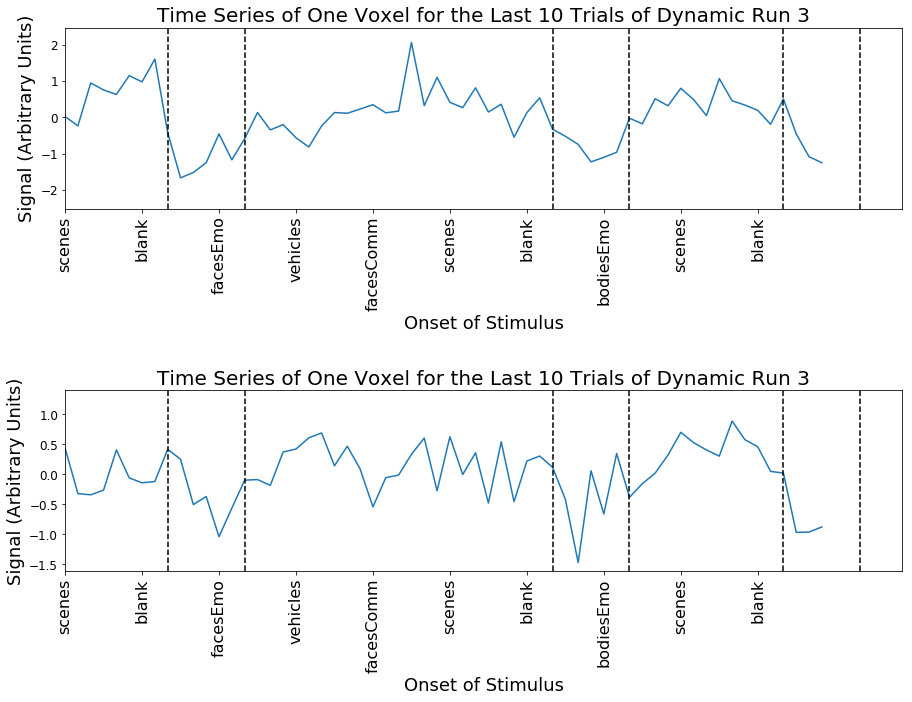

In [17]:
#Just to check to see how the timecourses look 3 to 7 seconds after the stimulus onset, I plotted the raw timeseries 
#for one voxel chosen at random for a randomly chosen run and roi. The two columns in the subplot below are the rois, 
#and the 4 rows are the 4 runs.

plt.subplots(2,1,figsize=(15,10))
for subplot in [1,2]:
    plt.subplot(2,1,subplot)
    roi = np.random.choice(range(2)) #Randomly selecting 1 or 2 rois
    voxel = np.random.choice(range(len(matlab_data['mvd'][run,roi])))
    plt.plot(matlab_data['mvd'][run,roi][0][:,voxel])
    plt.xlabel('Onset of Stimulus',fontsize=18)
    plt.xticks(np.array(range(66,126,6)),
               ['scenes','blank','facesEmo','vehicles','facesComm','scenes',
               'blank','bodiesEmo','scenes','blank'],rotation=90,fontsize=16)
    blank_onsets = [72,102,120]
    for onset in blank_onsets:
        plt.axvline(x=onset+2,color='k',linestyle='--')
        plt.axvline(x=onset+8,color='k',linestyle='--')
    plt.ylabel('Signal (Arbitrary Units)',fontsize=18)
    plt.title('Time Series of One Voxel for the Last 10 Trials of Dynamic Run 3',fontsize=20)
    plt.xlim(xmin=66)
    plt.yticks(fontsize=12)
plt.subplots_adjust(hspace=1)

From looking at the plots above, I decided to calculate the percent signal change with respect to the average of TRs 3 through after the start of the blank trial for each voxel.

In [18]:
#Instantiating dictionary to store averaged baseline time series
average_baseline = {}

for run in range(matlab_data['mvd'].shape[0]): #Looping over runs
    for roi in range(matlab_data['mvd'].shape[1]): #Looping over rois
        average4run = [] #Instantiating array of the last two TRs for each baseline trial
        baseline_indices = np.where(matlab_data['mvd'][run,roi][2][0,:-2] == 0)[0].astype(int) #Finding baseline indices
                                                                                            #in timeseriesByTrial for run-roi
        for i in range(baseline_indices.size):
            trial_timeseries = timeseriesByTrial[run,roi][int(baseline_indices[i])][3:,:] #The last 5 TRs from this blank trial
            avg_trial_tSeries = np.mean(trial_timeseries,axis=0) #Averaging last 5 TRs from blank trial for each voxel
            average4run.append(avg_trial_tSeries) #Adding averages
        #Averaging across blank trials in this run and storing in dictionary
        average_baseline[run,roi] = np.mean(np.array(average4run),axis=0)

In [19]:
average_baseline[2,1].shape #Contains the average of 3 through 7 TRs after each blank trial in the run for all voxels 
                            #in the roi

(72,)

## Percent signal change from baseline timecourse
According to mindhive at MIT (http://mindhive.mit.edu/node/86), to calculate the timecourse in percent signal change, divide every timepoint's intensity by the baseline, multiply by 100 and then subtract 100. I perform this operation below.

In [20]:
run = np.random.choice(range(4)) #Randomly selecting 1 of 4 runs
print(run)
#I randomly selected Dynamic Run 0. The last 10 stimuli presented on 
#this run are facesComm, blank, vehicles, bodiesEmo, vehicles, vehicles,
#blank, scenes, scenes, blank

1


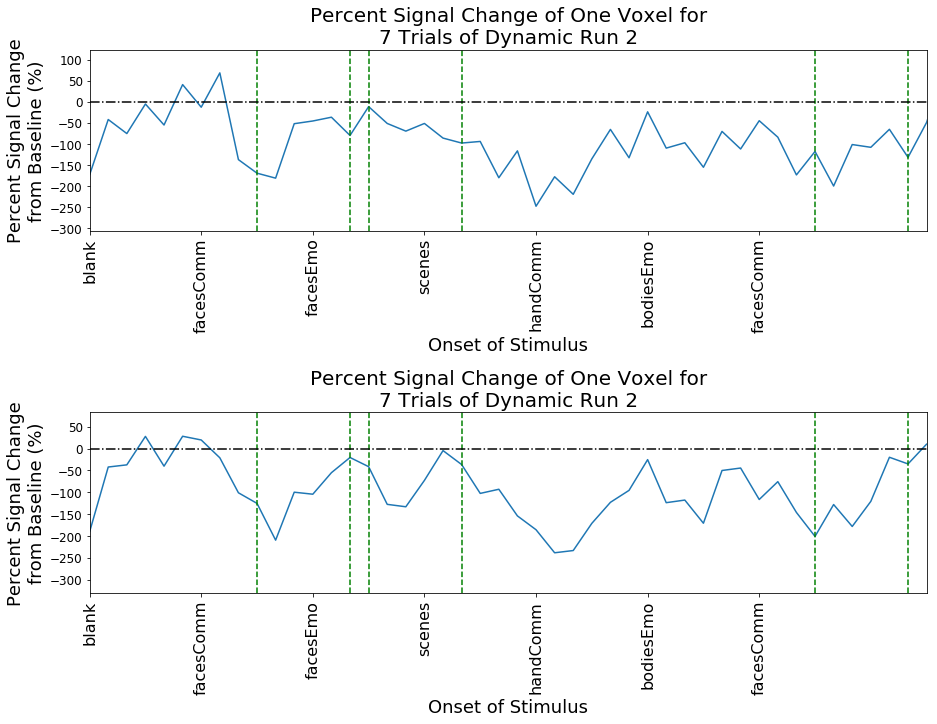

In [21]:
#Just to check to see how the timecourses will look after I calculate the percent signal change, I made the plots below.
plt.subplots(2,1,figsize=(15,10))
for subplot in [1,2]:
    roi = np.random.choice(range(2)) #Randomly selecting 1 of 2 rois
    voxel = np.random.choice(range(matlab_data['mvd'][run,roi][0].shape[1]))
    t = matlab_data['mvd'][run,roi][0]/average_baseline[run,roi]
    t = t*100
    t = t - 100
    plt.subplot(2,1,subplot)
    plt.plot(t[:,voxel])
    plt.xlabel('Onset of Stimulus',fontsize=18)
    plt.xticks(np.array(range(30,72,6)),['blank','facesComm','facesEmo','scenes','handComm',
                                        'bodiesEmo','facesComm','blank'],rotation=90,fontsize=16)
    plt.ylabel('Percent Signal Change\nfrom Baseline (%)',fontsize=18)
    plt.title('Percent Signal Change of One Voxel for\n7 Trials of Dynamic Run 2',fontsize=20)
    plt.yticks(fontsize=12)
    plt.xlim((30,75))
    faces_onsets = [36,42,66]
    for onset in faces_onsets:
        plt.axvline(x=onset+3,color='g',linestyle='--')
        plt.axvline(x=onset+8,color='g',linestyle='--')
    plt.axhline(y=0,color='k',linestyle='-.')
plt.subplots_adjust(hspace=1)

From the plots above, it looks like I should be fine if I average the percent signal changes 4 to 7 TRs after stimulus onset. So I will store all of these percent signal change time series in a dictionary

In [22]:
#Instantiating a new dictionary that will contain all of the percent signal change timeseries by run, roi and trial
percentChangeTSeries = {}

for run in range(matlab_data['mvd'].shape[0]): #Looping over runs
    for roi in range(matlab_data['mvd'].shape[1]): #Looping over rois
        percentChangeTSeries[(run,roi)] = []
        for trial in range(len(timeseriesByTrial[(run,roi)])):
            percentChangeTSeries[(run,roi)].append((timeseriesByTrial[(run,roi)][trial]/average_baseline[(run,roi)])[4:,:])
            percentChangeTSeries[(run,roi)][trial] = percentChangeTSeries[(run,roi)][trial]*100
            percentChangeTSeries[(run,roi)][trial] = percentChangeTSeries[(run,roi)][trial] - 100

In [23]:
len(percentChangeTSeries[0,0]) #This new dataset is a list of length number of trials

20

In [24]:
percentChangeTSeries[3,0][15].shape #Each list entry contains the percent signal changes 4 through 7 TRs after stimulus onset

(4, 35)

## Averaging Percent Signal Change from Last 3 TRs
From the percent signal change timecourse plotted above, it appears as though the signal peaked later than I previously anticiated. As I am unable to train the SVMs on all of the timepoints, I decided to average the final three timepoints for each trial.

In [25]:
meanPercentChangeTSeries = {}

for run in range(matlab_data['mvd'].shape[0]): #Looping over runs
    for roi in range(matlab_data['mvd'].shape[1]): #Looping over rois
        #Storing the average of the last two TRs in percentChangeTSeries for each trial
        meanPercentChangeTSeries[(run,roi)] = np.mean(percentChangeTSeries[run,roi],axis=1)

In [26]:
meanPercentChangeTSeries[0,0].shape #Takes on the shape number of trials by number of voxels, which is what I need for the
                                    #SVM

(20, 35)

# Splitting Data Into Training and Testing Sets
When I split the data, I would like my training and testing sets to be of equivalent size and have equal representation from all six categories and between dynamic and static stimuli.
## Splitting Beta Weights
As the betas were calculated for each run, it's best to split the runs. As there were 2 dynamic and 2 static runs, there are only 2 ways I can split the data:
Set 1
Training - Dynamic Run 2 and Static Run 2,
Testing - Dynamic Run 3 and Static Run 3;
Set 2
Training - Dynamic Run 3 and Static Run 2,
Testing - Dynamic Run 2 and Static Run 3.
Of course the training and testing assignments can be reversed, so I flipped a coin for each set to determine which run go into training and which are for testing.

In [27]:
beta_splits = {'mFus': {0: {'training_features': np.vstack([matlab_data['mvd'][0,0][3][:-1],matlab_data['mvd'][1,0][3][:-1]]), #Dynamic Run 2 and Static Run 2 betas
                            'testing_features':  np.vstack([matlab_data['mvd'][2,0][3][:-1],matlab_data['mvd'][3,0][3][:-1]]), #Dynamic Run 3 and Static Run 3 betas
                            'training_labels': np.concatenate((np.array(range(6)),np.array(range(6))))+1, #Right now, the labels are organized numerically
                            'testing_labels': np.concatenate((np.array(range(6)),np.array(range(6))))+1},
                        1: {'training_features': np.vstack([matlab_data['mvd'][2,0][3][:-1],matlab_data['mvd'][1,0][3][:-1]]), #Dynamic Run 3 and Static Run 2 betas
                            'testing_features':  np.vstack([matlab_data['mvd'][0,0][3][:-1],matlab_data['mvd'][3,0][3][:-1]]), #Dynamic Run 2 and Static Run 3 betas
                            'training_labels': np.concatenate((np.array(range(6)),np.array(range(6))))+1, #Right now, the labels are organized numerically
                            'testing_labels': np.concatenate((np.array(range(6)),np.array(range(6))))+1}},
               'pFus': {0: {'training_features': np.vstack([matlab_data['mvd'][0,1][3][:-1],matlab_data['mvd'][1,1][3][:-1]]), #Dynamic Run 2 and Static Run 2 betas
                            'testing_features':  np.vstack([matlab_data['mvd'][2,1][3][:-1],matlab_data['mvd'][3,1][3][:-1]]), #Dynamic Run 3 and Static Run 3 betas
                            'training_labels': np.concatenate((np.array(range(6)),np.array(range(6))))+1, #Right now, the labels are organized numerically
                            'testing_labels': np.concatenate((np.array(range(6)),np.array(range(6))))+1},
                        1: {'training_features': np.vstack([matlab_data['mvd'][2,1][3][:-1],matlab_data['mvd'][1,1][3][:-1]]), #Dynamic Run 3 and Static Run 2 betas
                            'testing_features':  np.vstack([matlab_data['mvd'][0,1][3][:-1],matlab_data['mvd'][3,1][3][:-1]]), #Dynamic Run 2 and Static Run 3 betas
                            'training_labels': np.concatenate((np.array(range(6)),np.array(range(6))))+1, #Right now, the labels are organized numerically
                            'testing_labels': np.concatenate((np.array(range(6)),np.array(range(6))))+1}}}
#I coded the labels and integers from 1 to 6 to match how they appear in the parfiles and in matlab_data

Right now, the betas are not shuffled, so I will need to define a function that is able to shuffle both the features and corresponding labels so that they remain matched up.

In [28]:
def unison_shuffling(a,b):
    """
        Shuffles a matrix and a list in unison so that the indices along the first dimension of the matrix still line up
        with the indices of the list
        
        arguments - 
            a - 2 dimensional matrix
            b - list with the same length as the first dimension in a
        
        returns - 
            shuffled matrix a and b"""
    assert a.shape[0] == len(b)
    #Generating random permutation of indices in a and b
    shuffled_indices = np.random.permutation(len(b))
    #Returning shuffled
    return a[shuffled_indices,:],b[shuffled_indices]

In [29]:
#Shuffling beta_splits
for roi in ['mFus','pFus']:
    for split in [0,1]:
        #Unison shuffling of training features and labels
        [beta_splits[roi][split]['training_features'],beta_splits[roi][split]['training_labels']] = unison_shuffling(beta_splits[roi][split]['training_features'],
                                                                                                                     beta_splits[roi][split]['training_labels'])
        #Unison shuffling of testing features and labels
        [beta_splits[roi][split]['testing_features'],beta_splits[roi][split]['testing_labels']] = unison_shuffling(beta_splits[roi][split]['testing_features'],
                                                                                                                     beta_splits[roi][split]['testing_labels'])

## Splitting Mean Percent Signal Change
Just like before, I can split by run using the same splits as the betas. However, I need to make sure that there is equal representation from each category for both the training and testing sets. In each of the 4 runs I am using, facesComm, facesEmo, bodiesEmo, and handComm were all presented twice in each run while vehicles and scenes were presented 4 times. Thus, I'll need to randomly choose 2 of the 4 trials with vehicles and scenes to add to the training and testing sets. I'll also want to exclude all of the trials with blank stimuli from the training and testing sets. I started this process by first organizing the data from each run.

In [30]:
#Instantiating dictionary containing the mean percent change time series elements to be used for training and testing
selectedMeanPercentChange = {}

for run in range(matlab_data['mvd'].shape[0]): #Looping over runs
    for roi in range(matlab_data['mvd'].shape[1]): #Looping over rois
        #Instantiating lists of labels and features for this run and roi
        labels4Run = []
        features4Run = []
        
        #Adding mean percent change for all trials with faces, bodies and hands
        #Boolean index for trials with these stimuli
        notVehiclesScenes = np.all([[matlab_data['mvd'][run,roi][2][0][:-2] > 0],
                                    [matlab_data['mvd'][run,roi][2][0][:-2] < 5]],axis=0)[0,:]
        #Adding category labels each trial in this run with faces, bodies or hands
        labels4Run = matlab_data['mvd'][run,roi][2][0][:-2][notVehiclesScenes]
        #Add mean percent change for trails with faces, bodies or hands
        features4Run = meanPercentChangeTSeries[run,roi][notVehiclesScenes,:]
        
        #Randomly choosing 2 trials with vehicles and 2 with scenes
        for label in [5,6]: #For trials with vehicles,scenes
            #Boolean indices with vehicles,scenes
            vehiclesScenesBool = [matlab_data['mvd'][run,roi][2][0][:-1] == label]
            #Converting to int indices
            trialsInt = np.array(range(len(matlab_data['mvd'][run,roi][2][0][:-1])))
            vehiclesScenesInt = trialsInt[vehiclesScenesBool]
            #Randomly choosing two of these 4 indices without replacement
            chosenVehiclesScenes = np.sort(np.random.choice(vehiclesScenesInt,size=2,replace=False))
            labels4Run = np.hstack((labels4Run,matlab_data['mvd'][run,roi][2][0][:-1][chosenVehiclesScenes]))
            features4Run = np.vstack((features4Run,meanPercentChangeTSeries[run,roi][chosenVehiclesScenes]))
        
        #Shuffling labels and features for this run
        [features4Run,labels4Run] = unison_shuffling(features4Run,labels4Run)
        
        #Adding labels and features to dictionary
        selectedMeanPercentChange[run,roi] = {'features': features4Run,
                                             'labels': labels4Run}

In [31]:
#Splitting Data by Runs using the same splits as before
percentChangeSplits = {'mFus': {0: {'training_features': np.vstack((selectedMeanPercentChange[0,0]['features'], #Dynamic 2
                                                                   selectedMeanPercentChange[1,0]['features'])), #Static 2
                                    'training_labels': np.hstack((selectedMeanPercentChange[0,0]['labels'], #Dynamic 2
                                                                   selectedMeanPercentChange[1,0]['labels'])), #Static 2
                                    'testing_features': np.vstack((selectedMeanPercentChange[2,0]['features'], #Dynamic 3
                                                                   selectedMeanPercentChange[3,0]['features'])), #Static 3
                                    'testing_labels': np.hstack((selectedMeanPercentChange[2,0]['labels'], #Dynamic 3
                                                                   selectedMeanPercentChange[3,0]['labels']))}, #Static 
                                1: {'training_features': np.vstack((selectedMeanPercentChange[2,0]['features'], #Dynamic 3
                                                                   selectedMeanPercentChange[1,0]['features'])), #Static 2
                                    'training_labels': np.hstack((selectedMeanPercentChange[2,0]['labels'], #Dynamic 3
                                                                   selectedMeanPercentChange[1,0]['labels'])), #Static 2
                                    'testing_features': np.vstack((selectedMeanPercentChange[0,0]['features'], #Dynamic 2
                                                                   selectedMeanPercentChange[3,0]['features'])), #Static 3
                                    'testing_labels': np.hstack((selectedMeanPercentChange[0,0]['labels'], #Dynamic 2
                                                                   selectedMeanPercentChange[3,0]['labels']))}}, #Static 3
                       'pFus': {0: {'training_features': np.vstack((selectedMeanPercentChange[0,1]['features'], #Dynamic 2
                                                                   selectedMeanPercentChange[1,1]['features'])), #Static 2
                                    'training_labels': np.hstack((selectedMeanPercentChange[0,1]['labels'], #Dynamic 2
                                                                   selectedMeanPercentChange[1,1]['labels'])), #Static 2
                                    'testing_features': np.vstack((selectedMeanPercentChange[2,1]['features'], #Dynamic 3
                                                                   selectedMeanPercentChange[3,1]['features'])), #Static 3
                                    'testing_labels': np.hstack((selectedMeanPercentChange[2,1]['labels'], #Dynamic 3
                                                                   selectedMeanPercentChange[3,1]['labels']))}, #Static 
                                1: {'training_features': np.vstack((selectedMeanPercentChange[2,1]['features'], #Dynamic 3
                                                                   selectedMeanPercentChange[1,1]['features'])), #Static 2
                                    'training_labels': np.hstack((selectedMeanPercentChange[2,1]['labels'], #Dynamic 3
                                                                   selectedMeanPercentChange[1,1]['labels'])), #Static 2
                                    'testing_features': np.vstack((selectedMeanPercentChange[0,1]['features'], #Dynamic 2
                                                                   selectedMeanPercentChange[3,1]['features'])), #Static 3
                                    'testing_labels': np.hstack((selectedMeanPercentChange[0,1]['labels'], #Dynamic 2
                                                                   selectedMeanPercentChange[3,1]['labels']))}}} #Static 3

In [32]:
#Like with the betas, I'll want to shuffle the features and labels
for roi in ['mFus','pFus']:
    for split in [0,1]:
        #Unison shuffling of training features and labels
        [percentChangeSplits[roi][split]['training_features'],percentChangeSplits[roi][split]['training_labels']] = unison_shuffling(percentChangeSplits[roi][split]['training_features'],
                                                                                                                     percentChangeSplits[roi][split]['training_labels'])
        #Unison shuffling of testing features and labels
        [percentChangeSplits[roi][split]['testing_features'],percentChangeSplits[roi][split]['testing_labels']] = unison_shuffling(percentChangeSplits[roi][split]['testing_features'],
                                                                                                                     percentChangeSplits[roi][split]['testing_labels'])

# Training and Testing SVMs
I can now train and test different SVM models on my training/testing splits. To do this, I'll define a function below.

In [33]:
def train_test_svm(splits,roi,return_model=False):
    """
        Trains and Tests SVM Classifiers on training/testing sets for a particular roi and returns the mean accuracies
        
        arguments:
            splits - dictionary organized so that splits['mFus'][0] has the keys 'training_features','training_labels',
                     'testing_labels','testing_features' for the indicated roi (mFus) and split index (0)
            roi - which roi to train and test models on (i.e 'mFus' or 'pFus')
            return_models - should the models be outputted
            
        returns:
            dictionary of mean accuracies with the keys 'training' and 'testing', each holding lists of the mean accuracies
            for each split; the dictionary also has key 'confusionMatrix' containing the confusion matrix on the testing data
            if return_models=True, will also return the models for each split
    """
    
    #Instantiating lists of mean accuracies, confusion matrices, and models
    train_accuracies = []
    test_accuracies = []
    test_confMat = []
    models = []
    
    for split in [0,1]: #There are only 2 splits
        #Instantiating classifier using GridSearchCV, which will use cross validation to find the best parameters in 
        #tuned_parameters
        clf = SVM()
        
        #Fitting model to training data
        clf.fit(splits[roi][split]['training_features'],splits[roi][split]['training_labels'])
        
        #Calculatin training and testing accuracies and adding them to the lists
        train_accuracies.append(clf.score(splits[roi][split]['training_features'],splits[roi][split]['training_labels']))
        test_accuracies.append(clf.score(splits[roi][split]['testing_features'],splits[roi][split]['testing_labels']))
        
        #Getting confusion matrices on testing
        test_predictions = clf.predict(splits[roi][split]['testing_features'])
        test_confMat.append(confusion_matrix(splits[roi][split]['testing_labels'],
                                            test_predictions))
        
        #Storing model
        models.append(clf)
    
    #Combining train_accuracies, test_accuracies and confusion matrices into a dictionary
    results = {'training': train_accuracies, 'testing': test_accuracies, 'confusionMatrix': test_confMat}
    
    #Returning desired variables
    if return_model:
        return results, models
    else:
        return results

In [34]:
#Training and testing using the betas from mFus
results_beta_mFus = train_test_svm(beta_splits,'mFus')
print('testing')
print(results_beta_mFus['testing'])
print('training')
print(results_beta_mFus['training'])

testing
[0.3333333333333333, 0.5]
training
[0.9166666666666666, 0.9166666666666666]


In [35]:
#Training and testing using the betas from pFus
results_beta_pFus = train_test_svm(beta_splits,'pFus')
print('testing')
print(results_beta_pFus['testing'])
print('training')
print(results_beta_pFus['training'])

testing
[0.5, 0.4166666666666667]
training
[1.0, 1.0]


In [36]:
#Training and testing using percent change from mFus
results_percent_mFus = train_test_svm(percentChangeSplits,'mFus')
print('testing')
print(results_percent_mFus['testing'])
print('training')
print(results_percent_mFus['training'])

testing
[0.16666666666666666, 0.16666666666666666]
training
[1.0, 1.0]


In [37]:
#Training and testing using percent change from mFus
results_percent_pFus = train_test_svm(percentChangeSplits,'pFus')
print('testing')
print(results_percent_pFus['testing'])
print('training')
print(results_percent_pFus['training'])

testing
[0.16666666666666666, 0.16666666666666666]
training
[1.0, 1.0]


Text(0.5,1,'Performance of Decoding Models')

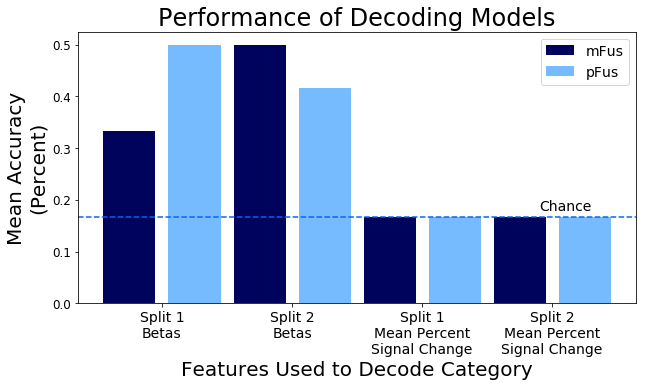

In [38]:
plt.figure(figsize=(10,5))
mFus = plt.bar(np.arange(4)*2,[results_beta_mFus['testing'][0],
                      results_beta_mFus['testing'][1],results_percent_mFus['testing'][0],
                      results_percent_mFus['testing'][1]],color='xkcd:dark blue')

pFus = plt.bar(np.arange(4)*2+1,[results_beta_pFus['testing'][0],
                      results_beta_pFus['testing'][1],results_percent_pFus['testing'][0],
                    results_percent_pFus['testing'][1]],color='xkcd:sky blue')

plt.legend((mFus,pFus),('mFus','pFus'),fontsize=14)
plt.axhline(y=0.16666667,color='xkcd:bright blue',linestyle='--')
plt.text(6.3,.18,'Chance',fontsize=14)
plt.xticks(np.arange(4)*2+.5,('Split 1\nBetas','Split 2\nBetas','Split 1\nMean Percent\nSignal Change',
                             'Split 2\nMean Percent\nSignal Change'),fontsize=14)
plt.yticks(fontsize=12)
plt.xlabel('Features Used to Decode Category',fontsize=20)
plt.ylabel('Mean Accuracy\n(Percent)',fontsize=20)
plt.title('Performance of Decoding Models',fontsize=24)

## Displaying Confusion Matrices
To see which categories the SVM is good at predicting, I want to visualize the confusion matrices. To do this, I'll define a separate function.

In [39]:
#Defining list of category names
categories = ['facesEmo','facesComm','bodiesEmo','handComm','vehicles','scenes']

In [40]:
def visualize_confmat(cmat, ucats=categories, fig=None):
    """
        Visualize confusion matrix
        
        arguments:
            cmat - confusion matrix from train_test_svm
            ucats - names of unique categories
            fig - whether or not a figure is currently in use
    """
    #Plotting matrix using colormap winter
    if fig is None:
        plt.matshow(cmat,cmap='summer',vmin=0,vmax=2.5)
    else:
        fig.gca().matshow(cmat)
    #Adding actual numbers to confusion matrix
    for i in range(cmat.shape[0]):
        for j in range(cmat.shape[1]):
            if cmat[i,j] == 2:
                plt.text(j-.1, i, '%.0f' % (cmat[i, j]), color='xkcd:evergreen')
            else:
                plt.text(j-.1, i, '%.0f' % (cmat[i, j]), color='w')
    #Adding labels
    M = len(ucats)
    plt.xticks(np.arange(M), ucats,rotation=90,fontsize=14)
    plt.yticks(np.arange(M), ucats,fontsize=14)
    plt.xlabel('Predicted',fontsize=16)
    plt.ylabel('Actual',fontsize=16)

Ideal Confusion Matrix


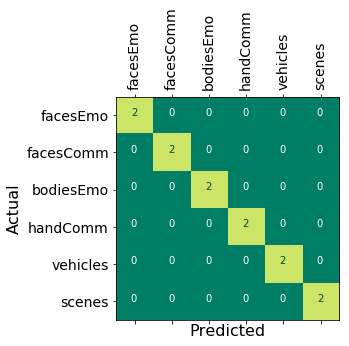

In [41]:
print('Ideal Confusion Matrix')
visualize_confmat(np.diag(np.ones(6,)*2))


Confusion Matrix for mFus on the Betas, Split 1


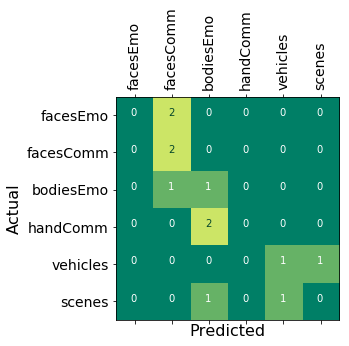

In [42]:
print('Confusion Matrix for mFus on the Betas, Split 1')
visualize_confmat(results_beta_mFus['confusionMatrix'][0])

Confusion Matrix for mFus on the Betas, Split 2


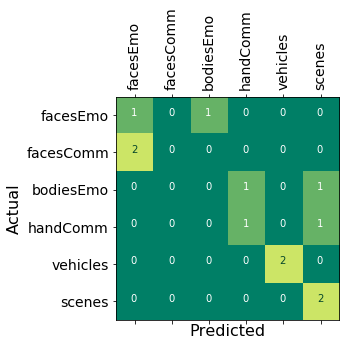

In [43]:
print('Confusion Matrix for mFus on the Betas, Split 2')
visualize_confmat(results_beta_mFus['confusionMatrix'][1])

Confusion Matrix for pFus on the Betas, Split 1


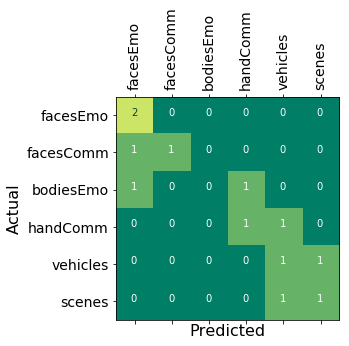

In [44]:
print('Confusion Matrix for pFus on the Betas, Split 1')
visualize_confmat(results_beta_pFus['confusionMatrix'][0])

Confusion Matrix for pFus on the Betas, Split 2


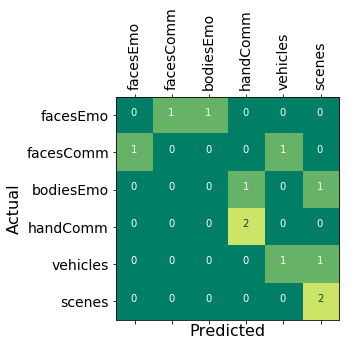

In [45]:
print('Confusion Matrix for pFus on the Betas, Split 2')
visualize_confmat(results_beta_pFus['confusionMatrix'][1])